<center><h1>Saravanan_Praveen_HW7</h1></center>

Name: Praveen Saravanan
<br>
Github Username: Michael-on-the-Microphone
<br>
USC ID: 7939976839

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score)
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

RNG = 42     
LABELS = ['Family', 'Genus', 'Species']

In [2]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*failed to converge.*")

### (a) Download the Anuran Calls (MFCCs) Data Set

In [3]:
df = pd.read_csv('../data/Frogs_MFCCs.csv')

mfcc_cols = [c for c in df.columns if c.startswith('MFCC')]
X = df[mfcc_cols]    

LABELS = ['Family', 'Genus', 'Species']
y_raw = df[LABELS]

encoders = {c: LabelEncoder().fit(y_raw[c]) for c in LABELS}
y = pd.DataFrame({c: encoders[c].transform(y_raw[c]) for c in LABELS})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42, stratify=y)
print(f"Shape X_train: {X_train.shape}  –  (should be 22 numeric cols)")

Shape X_train: (5036, 22)  –  (should be 22 numeric cols)


### (b) Train a classifier for each label

#### (i) Research

### Exact-Match
* Measures the percentage of instances for which **all** predicted labels match **all** true labels exactly.

### Hamming Score / Hamming Loss
* **Hamming loss** – fraction of incorrect label assignments (0 = perfect, 1 = worst).  
* **Hamming score** – 1 − loss (higher is better).

#### (ii) Train a SVM for each of the labels

In [4]:
def exact_match_score(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    return (y_true.values == y_pred.values).all(axis=1).mean()

def hamming_loss_mcml(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    return (y_true.values != y_pred.values).mean()

def hamming_score_mcml(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    return 1.0 - hamming_loss_mcml(y_true, y_pred)

# dummy = y_test.copy()
# print(exact_match_score(y_test, dummy), hamming_loss_mcml(y_test, dummy))

In [5]:
def summarize_results(result_dict):
    rows = []
    for lbl, res in result_dict.items():
        rows.append({
            'Label': lbl,
            'Best C': res['best_params'].get('C'),
            'Best Y': res['best_params'].get('gamma', '—'),
            'Exact-match': f"{res['exact_match']:.3f}",
            'Hamming score': f"{res['hamming_score']:.3f}"
        })
    return pd.DataFrame(rows).set_index('Label')

In [6]:
param_grid_rbf = {
    'C':     np.logspace(-3, 6, 10),
    'gamma': np.linspace(0.1, 2.0, 10)
}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RNG)

rbf_results = {}
for lbl in LABELS:
    svc = SVC(kernel='rbf', decision_function_shape='ovr', probability=True)            
    grid = GridSearchCV(svc, param_grid_rbf, cv=cv, scoring='accuracy', n_jobs=-1, verbose=0)
    grid.fit(X_train, y_train[lbl])
    
    best = grid.best_estimator_
    y_pred = pd.DataFrame({lbl: best.predict(X_test)})
    
    rbf_results[lbl] = {
        'best_params': grid.best_params_,
        'best_estimator': best,
        'exact_match': accuracy_score(y_test[lbl], y_pred[lbl]),
        'hamming_score': hamming_score_mcml(y_test[[lbl]], y_pred)
    }

print("RBF-SVM (one-vs-rest):")
summarize_results(rbf_results)

RBF-SVM (one-vs-rest):


,Best C,Best Y,Exact-match,Hamming score
Label,,,,
Family,100.0,2.000000,0.994,0.994
Genus,10.0,1.366667,0.989,0.989
Species,10.0,1.577778,0.988,0.988


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [7]:
scaler = StandardScaler().fit(X_train)
Xtr_std, Xte_std = scaler.transform(X_train), scaler.transform(X_test)

param_grid_l1 = {'C': np.logspace(-3, 3, 7)}

l1_results = {}
for lbl in LABELS:
    lsvc = LinearSVC(penalty='l1', dual=False, max_iter=6000)
    grid = GridSearchCV(lsvc, param_grid_l1, cv=cv, scoring='accuracy', n_jobs=1)
    grid.fit(Xtr_std, y_train[lbl])
    
    best = grid.best_estimator_
    y_pred = pd.DataFrame({lbl: best.predict(Xte_std)})
    
    l1_results[lbl] = {
        'best_params': grid.best_params_,
        'best_estimator': best,
        'exact_match': accuracy_score(y_test[lbl], y_pred[lbl]),
        'hamming_score': hamming_score_mcml(
            y_test[[lbl]], y_pred
        )
    }

print("Linear SVM (L1 penalty):")
summarize_results(l1_results)

Linear SVM (L1 penalty):


,Best C,Best Y,Exact-match,Hamming score
Label,,,,
Family,100.0,—,0.940,0.940
Genus,100.0,—,0.951,0.951
Species,1.0,—,0.962,0.962


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [8]:
smote_results = {}
for lbl in LABELS:
    sm = SMOTE(random_state=RNG)
    X_res, y_res = sm.fit_resample(Xtr_std, y_train[lbl])
    
    best_C = l1_results[lbl]['best_params']['C']
    clf = LinearSVC(penalty='l1', dual=False, C=best_C, max_iter=6000)
    clf.fit(X_res, y_res)
    
    y_pred = pd.DataFrame({lbl: clf.predict(Xte_std)})
    smote_results[lbl] = {
        'best_params': {'C': best_C},
        'best_estimator': clf,
        'exact_match': accuracy_score(y_test[lbl], y_pred[lbl]),
        'hamming_score': hamming_score_mcml(
            y_test[[lbl]], y_pred
        )
    }

print("Linear SVM + SMOTE:")
summarize_results(smote_results)

Linear SVM + SMOTE:


,Best C,Best Y,Exact-match,Hamming score
Label,,,,
Family,100.0,—,0.920,0.920
Genus,100.0,—,0.908,0.908
Species,1.0,—,0.958,0.958


Adding SMOTE lowered accuracy a little (Family 0.94 -> 0.92, Genus 0.951 -> 0.908, Species 0.962 -> 0.958).

### Extra Practice 

In [9]:
metrics = {}
for lbl in LABELS:
    best = rbf_results[lbl]['best_estimator']
    
    y_true = y_test[lbl]
    y_pred = best.predict(X_test)
    y_proba = best.predict_proba(X_test)
    
    metrics[lbl] = {
        'precision': precision_score(y_true, y_pred, average='macro'),
        'recall':    recall_score(y_true, y_pred, average='macro'),
        'auc':       roc_auc_score(pd.get_dummies(y_true), y_proba, average='macro', multi_class='ovr'),
        'conf_mtx':  confusion_matrix(y_true, y_pred)
    }

for lbl, m in metrics.items():
    print(f"\n▶ {lbl}")
    print(f"  Precision: {m['precision']:.3f}  •  Recall: {m['recall']:.3f}  •  AUC: {m['auc']:.3f}")
    print("  Confusion matrix:\n", m['conf_mtx'])



▶ Family
  Precision: 0.996  •  Recall: 0.997  •  AUC: 1.000
  Confusion matrix:
 [[  20    0    0    0]
 [   0  163    0    0]
 [   0    0  645    4]
 [   0    0    9 1318]]

▶ Genus
  Precision: 0.973  •  Recall: 0.978  •  AUC: 1.000
  Confusion matrix:
 [[1238    0    6    1    0    1    0    0]
 [   0  162    1    0    0    0    0    0]
 [   6    0   87    0    0    0    0    0]
 [   0    0    0  474    1    3    0    0]
 [   0    0    1    0   80    0    0    0]
 [   1    0    0    1    0   32    0    0]
 [   0    0    0    0    0    0   20    0]
 [   1    0    0    0    0    0    0   43]]

▶ Species
  Precision: 0.972  •  Recall: 0.975  •  AUC: 1.000
  Confusion matrix:
 [[ 198    0    0    3    0    0    0    1    0    0]
 [   0 1041    0    2    0    1    0    0    0    0]
 [   0    0  162    1    0    0    0    0    0    0]
 [   1    3    0   89    0    0    0    0    0    0]
 [   1    0    0    0  135    2    0    4    0    0]
 [   1    0    0    0    0  334    0    1    0  

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X_all = X.values      

sil = []
for k in range(2, 51):
    km = KMeans(n_clusters=k, random_state=RNG, n_init='auto').fit(X_all)
    sil.append(silhouette_score(X_all, km.labels_))
best_k = np.argmax(sil) + 2
print("Best k by silhouette:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=RNG, n_init='auto').fit(X_all)
clusters = kmeans.labels_

Best k by silhouette: 4


### (b) Determine which family is the majority

In [11]:
df_cl = df[LABELS].copy()
df_cl['cluster'] = clusters

majority_tbl = df_cl.groupby('cluster')[LABELS] \
                    .agg(lambda s: s.mode().iat[0])
majority_tbl.head()


,Family,Genus,Species
cluster,,,
0,Leptodactylidae,Adenomera,AdenomeraHylaedactylus
1,Hylidae,Hypsiboas,HypsiboasCinerascens
2,Dendrobatidae,Ameerega,Ameeregatrivittata
3,Hylidae,Hypsiboas,HypsiboasCordobae


### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [12]:
def triplet_hd(true_triplet, pred_triplet):
    return np.mean(np.array(true_triplet) != np.array(pred_triplet))

hd = []
for idx, row in df_cl.iterrows():
    true_vals = row[LABELS].values
    pred_vals = majority_tbl.loc[row['cluster']].values
    hd.append(triplet_hd(true_vals, pred_vals))

avg_hd  = np.mean(hd)
avg_hs  = 1 - avg_hd
avg_hl  = avg_hd        

print(f"Avg Hamming distance: {avg_hd:.4f}")
print(f"Avg Hamming score:    {avg_hs:.4f}")
print(f"Hamming loss:         {avg_hl:.4f}")

Avg Hamming distance: 0.2224
Avg Hamming score:    0.7776
Hamming loss:         0.2224


## 3. ISLR 12.6.2

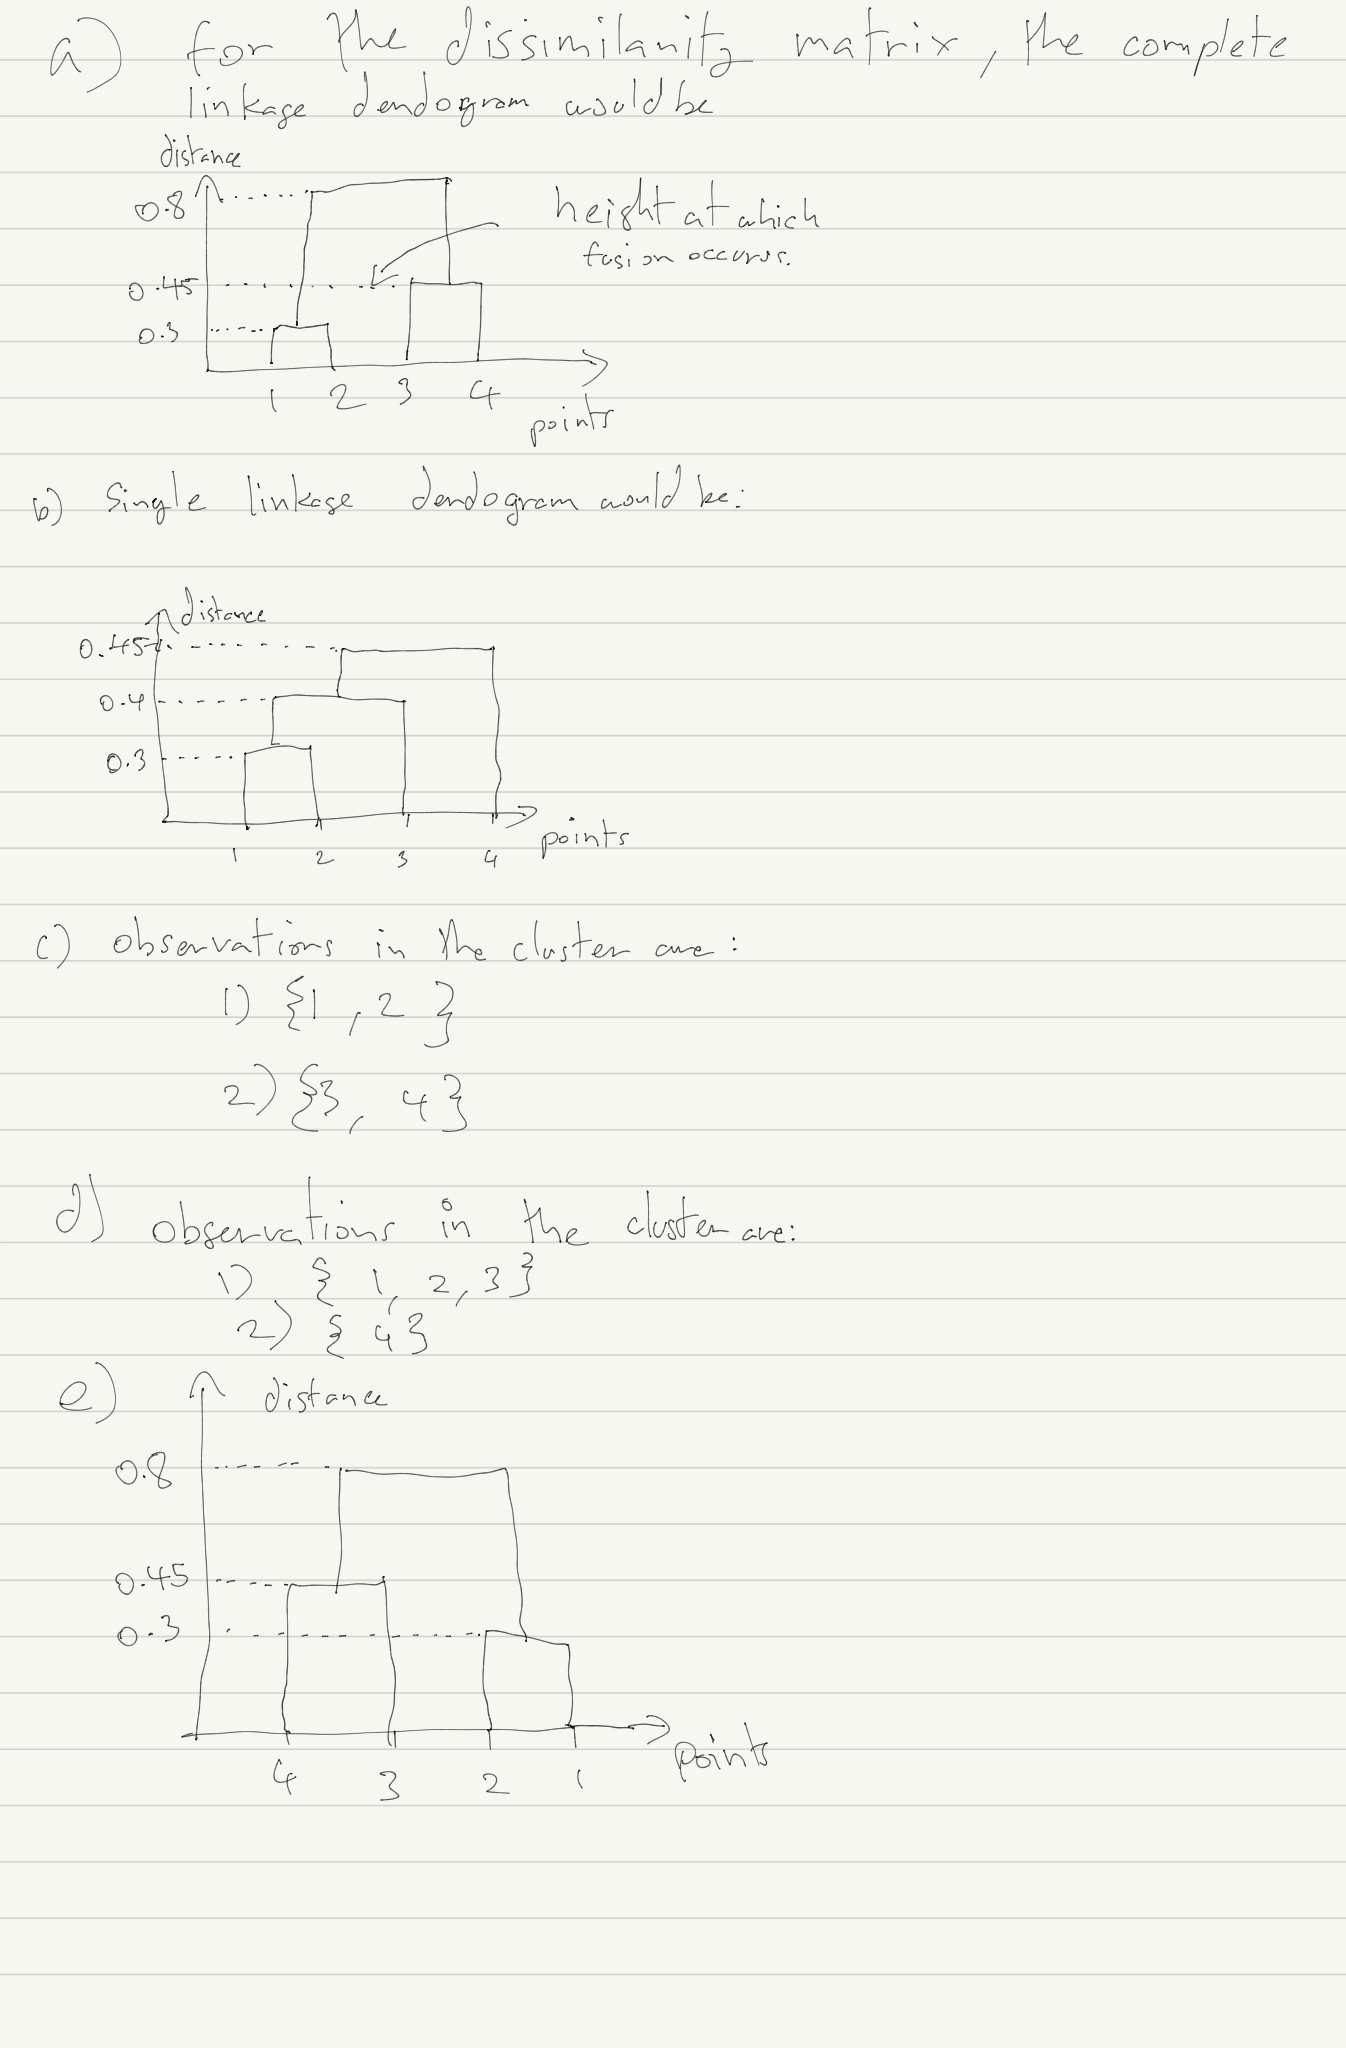

In [13]:
from IPython.display import Image, display
display(Image(filename='islr.png'))